In [5]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import matplotlib.pyplot as plt
# from sklearn_evaluation import plot

print("Imports complete")

Imports complete


In [ ]:
# Load the data from the text file, ignoring the first line

filename="./data/MiniBooNE_PID.txt"
data=pd.read_csv(filename,delim_whitespace=True,skiprows=1,header=None)
print(data.head(1))
X=data

In [ ]:
""" Create target vector for each row of the dataset. 
The first value in the first row contains the number of signal events, the second the number of background events. 
The target vector should contain 1 for signal events and 0 for background events."""

# Get number of signal and background events
signal, background = open(filename).readline().split()

y = np.concatenate((np.ones(int(signal)), np.zeros(int(background))))
print(y.shape)

Standardization scales the input features to have a mean of 0 and a standard deviation of 1

In [ ]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
""" save the scaled matrix and the target vector as npy files """
np.save('X.npy', X_scaled)
np.save('y.npy', y)

In [7]:
X=np.load('X.npy') # load the scaled matrix
y=np.load('y.npy')

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Create a vanilla neural network classifier and train it on the training data
nn_clf = MLPClassifier(random_state=42)

# Define the hyperparameter space to search over for the vanilla neural network classifier
nn_param_grid = {
    'hidden_layer_sizes': [(40,), (40,40), (40,40,40), (40,40,40,40)],
    # 'hidden_layer_sizes': [(30,), (30,30), (30,30,30), (30,30,30,30)],
    # 'activation': ["relu", "logistic", "tanh", "identity"],
    # 'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
    'random_state': [42]
}

# Set up the grid search using 5-fold cross-validation
nn_grid_search = GridSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy',verbose=10)
# nn_grid_search = RandomizedSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy', n_iter=2)

# Perform the grid search on the training set
nn_start_time = time.time()
nn_grid_search.fit(X_train, y_train)
nn_end_time = time.time()
print('Time required to grid search Vanilla Neural Network classifier:', nn_end_time - nn_start_time)

# Print the best hyperparameters and the best cross-validation accuracy
print('Vanilla Neural Network best hyperparameters:', nn_grid_search.best_params_)
print('Vanilla Neural Network best cross-validation accuracy:', nn_grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START hidden_layer_sizes=(40,), max_iter=500, random_state=42.....
[CV 1/5; 1/4] END hidden_layer_sizes=(40,), max_iter=500, random_state=42;, score=0.936 total time= 1.1min
[CV 2/5; 1/4] START hidden_layer_sizes=(40,), max_iter=500, random_state=42.....
[CV 2/5; 1/4] END hidden_layer_sizes=(40,), max_iter=500, random_state=42;, score=0.936 total time= 1.1min
[CV 3/5; 1/4] START hidden_layer_sizes=(40,), max_iter=500, random_state=42.....
[CV 3/5; 1/4] END hidden_layer_sizes=(40,), max_iter=500, random_state=42;, score=0.934 total time= 1.4min
[CV 4/5; 1/4] START hidden_layer_sizes=(40,), max_iter=500, random_state=42.....
[CV 4/5; 1/4] END hidden_layer_sizes=(40,), max_iter=500, random_state=42;, score=0.932 total time=  58.6s
[CV 5/5; 1/4] START hidden_layer_sizes=(40,), max_iter=500, random_state=42.....
[CV 5/5; 1/4] END hidden_layer_sizes=(40,), max_iter=500, random_state=42;, score=0.938 total time= 1.6min


In [22]:
# Re-train the classifier using the best hyperparameters on the full training set
nn_clf = nn_grid_search.best_estimator_

nn_start_time = time.time()
nn_clf.fit(X_train, y_train)
nn_end_time = time.time()

# Evaluate the classifier on the test set
# nn_test_accuracy = nn_clf.score(X_test, y_test)
nn_test_accuracy = nn_grid_search.score(X_test, y_test)
print('Time required to train Vanilla Neural Network classifier:', nn_end_time - nn_start_time)
print('Vanilla Neural Network test accuracy:', nn_test_accuracy)

Time required to train Vanilla Neural Network classifier: 134.89314246177673
Vanilla Neural Network test accuracy: 0.9390689270749241


In [27]:
# Get the results of the grid search
nn_results = nn_grid_search.cv_results_

# Get the mean and standard deviation for each hyperparameter combination
nn_mean_scores = nn_results['mean_test_score']
nn_mean_times = nn_results['mean_fit_time']
nn_params = nn_results['param_hidden_layer_sizes']

# Loop through each combination of hyperparameters
for mean_score, mean_time, param in zip(nn_mean_scores, nn_mean_times, nn_params):
    print("HiddenLayerSize: %r | %.2fs | test-score: %f" % (param, mean_time, mean_score))

HiddenLayerSize: (40,) | 75.29s | test-score: 0.935311
HiddenLayerSize: (40, 40) | 86.75s | test-score: 0.936723
HiddenLayerSize: (40, 40, 40) | 163.92s | test-score: 0.934984
HiddenLayerSize: (40, 40, 40, 40) | 249.26s | test-score: 0.932158


/tmp/ipykernel_4109702/2129472787.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot([1,2,3,4], nn_mean_scores, 'o-', label="Mean Score", linestyle=':')


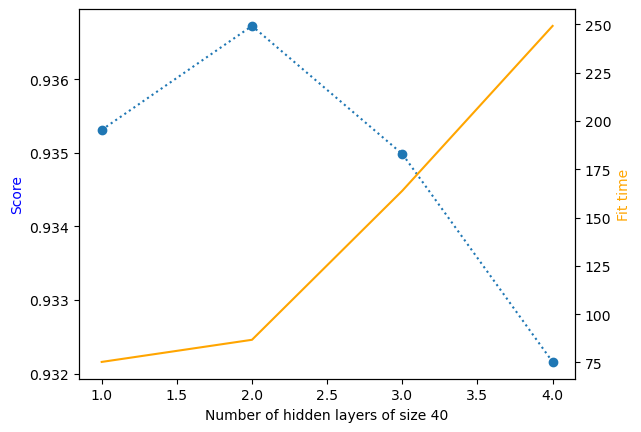

In [31]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot([1,2,3,4], nn_mean_scores, 'o:', label="Mean Score", linestyle=':')
ax2.plot([1,2,3,4], nn_mean_times, 'o:',color='orange', label="Mean Fit Time")
ax1.set_xlabel('Number of hidden layers of size 40')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time [s]', color='orange')

plt.show()

In [56]:
from thundersvm import SVC

In [9]:
# Create a SVM classifier and train it on the training data
svm_clf = SVC(kernel="rbf",random_state=42)

svm_param_grid = {
    # 'kernel': ['linear','rbf', 'poly', 'sigmoid'],
    'C': [10],
    'gamma': ['auto'],
    'random_state': [42],
}

svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=5, scoring='accuracy', verbose=10)

svm_start_time = time.time()
svm_grid_search.fit(X_train, y_train)
svm_end_time = time.time()

print('SVM best hyperparameters:', svm_grid_search.best_params_)
print('SVM best cross-validation accuracy:', svm_grid_search.best_score_)
print('Time required to perform GridSearch on SVM classifier:', svm_end_time - svm_start_time, 'seconds')

SVM best hyperparameters: {'C': 10, 'random_state': 42}
SVM best cross-validation accuracy: 0.9066611484782229
Time required to train SVM classifier: 4058.4434032440186
SVM test accuracy: 0.908468842501826


In [14]:
svm_clf = svm_grid_search.best_estimator_

svm_clf.fit(X_train, y_train)

svm_test_accuracy = svm_grid_search.score(X_test, y_test)
print('Time required to train SVM classifier:', svm_end_time - svm_start_time)
print('SVM test accuracy:', svm_test_accuracy)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Time required to train SVM classifier: 4058.4434032440186
SVM test accuracy: 0.908468842501826


In [58]:
# Get the results of the grid search
svm_results = svm_grid_search.cv_results_

svm_mean_scores = svm_results['mean_test_score']
svm_mean_score_times = svm_results['mean_score_time']
svm_mean_fit_times = svm_results['mean_fit_time']
svm_param_C = svm_results['param_C']

for mean_score, mean_score_time, mean_fit_time, param in zip(svm_mean_scores, svm_mean_score_times, svm_mean_fit_times, svm_param_C):
    print("C: %r | %.2fs | test-score: %f" % (param, mean_fit_time, mean_score))

C: 0.1 | 331.12s | test-score: 0.877185
C: 1 | 160.40s | test-score: 0.891601
C: 10 | 148.25s | test-score: 0.906661


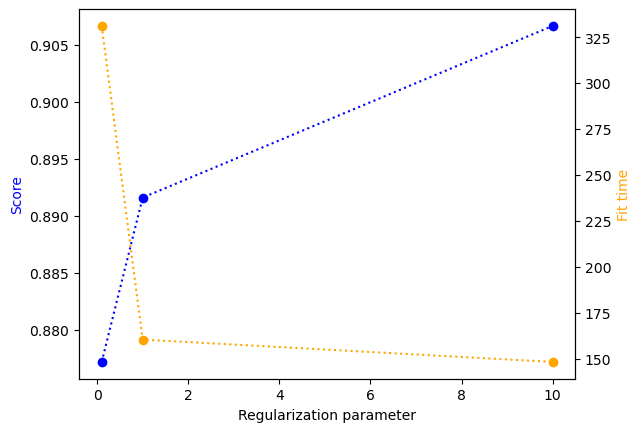

In [55]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(svm_param_C, svm_mean_scores,'o:', color='blue', label="Mean Score")
ax2.plot(svm_param_C, svm_mean_fit_times,'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel('Regularization parameter')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time', color='orange')

plt.show()

In [ ]:
# Create a random forest classifier and train it on the training data
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [10, 50, 100, 200],
    # "max_depth": [None, 10, 20, 30],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": ["sqrt", "log2", None]
    'random_state': [42]
}

rf_grid_search = GridSearchCV(rf_clf, svm_param_grid, cv=5, scoring='accuracy')

rf_start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_end_time = time.time()

print('RF best hyperparameters:', rf_grid_search.best_params_)
print('RF best cross-validation accuracy:', rf_grid_search.best_score_)

rf_clf = rf_grid_search.best_estimator_
# rf_clf.fit(X_train, y_train)

rf_test_accuracy = rf_grid_search.score(X_test, y_test)
print('Time required to train RF classifier:', rf_end_time - rf_start_time)
print('RF test accuracy:', rf_test_accuracy)

In [ ]:
# Generate predictions for the test set
nn_predictions = nn_clf.predict(X_test)
svm_predictions = svm_clf.predict(X_test)
rf_predictions = rf_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

# Define a dictionary that maps model names to their hyperparameters
model_hyperparams = {
    'Vanilla Neural Network': nn_grid_search.best_params_,
    'SVM': svm_grid_search.best_params_,
    'Random Forest': rf_grid_search.best_params_
}

# Compute the confusion matrix for each model
nn_confusion_matrix = metrics.confusion_matrix(y_test, nn_predictions)
svm_confusion_matrix = metrics.confusion_matrix(y_test, svm_predictions)
rf_confusion_matrix = metrics.confusion_matrix(y_test, rf_predictions)

# Print the confusion matrix and hyperparameters for each model
print('Vanilla Neural Network confusion matrix:')
print(nn_confusion_matrix)
print('Vanilla Neural Network hyperparameters:', model_hyperparams['Vanilla Neural Network'])

print('SVM confusion matrix:')
print(svm_confusion_matrix)
print('SVM hyperparameters:', model_hyperparams['SVM'])

print('Random Forest confusion matrix:')
print(rf_confusion_matrix)
print('Random Forest hyperparameters:', model_hyperparams['Random Forest'])

In [ ]:
# Evaluate the performance of each classifier
nn_accuracy = metrics.accuracy_score(y_test, nn_predictions)
svm_accuracy = metrics.accuracy_score(y_test, svm_predictions)
rf_accuracy = metrics.accuracy_score(y_test, rf_predictions)
print("Vanilla Neural Network Accuracy:", nn_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

In [52]:
from joblib import dump, load


In [53]:
dump(nn_clf, 'nn_clf.joblib')

['nn_clf.joblib']

In [54]:
dump(svm_clf, 'svm_clf.joblib')

['svm_clf.joblib']

In [ ]:
dump(rf_clf, 'rf_clf.joblib')

In [ ]:
nn_clf = load('nn_clf.joblib')

In [ ]:
svm_clf = load('svm_clf.joblib')

In [ ]:
rf_clf = load('rf_clf.joblib')